# Sistema de Compressão

$ \frac{d\dot{m}}{dt} = \frac{A_1}{L_C}(\phi (N(t), \dot{m})P_1 - P_P(t)) $

$ \frac{d P_P}{dt} = \frac{C_1^2}{\nu _P}(\dot{m}(t) - \alpha (t) K_\nu \sqrt{P_P - P_{out}}) $

$ \begin{matrix} A_1 & = & 2.6\centerdot 10^{-3} m² \\
\nu _P & = & 2.0 m³ \\
L_C & = & 2.0 m \\
K_\nu & = & \frac{0.38 kg}{(kPa)^{0.5}s} \\
P_1 & = & 4.5 MPa \\
P{out} & = & 5.0 MPa \end{matrix}
$

$ \frac{d\dot{m}}{dt} = \frac{2.6\centerdot 10^{-3}}{2.0}(\phi (N(t), \dot{m})\centerdot 4.5 - P_P) $

$ \frac{d P_P}{dt} = \frac{479.029^2}{2.0}(\dot{m} - \alpha {0.38} \sqrt{P_P - 5.0}) $

#### Importações

In [7]:
import numpy as np
from scipy.optimize import fsolve
import casadi as ca
import plotly.graph_objects as go
import optuna
from plotly.subplots import make_subplots
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from scipy.interpolate import griddata
from libs.simulationn import Simulation
from libs.Model import MyModel
from libs.Interpolation import Interpolation

#### Constantes e Variáveis Auxiliares

In [8]:

np.random.seed(42)
print(np.random.seed)

# Constantes
A1 = (2.6)*(10**-3)
Lc = 2
kv = 0.38
P1 = 4.5
P_out = 5
C = 479

timestep = 3 # Passos no passado para prever o próximo
nAlphas = 20 # Número de vezes que o Alfa irá mudar, considere o treino e os testes.
alphas = np.random.uniform(0.35,0.65, nAlphas+1) # Abertura da válvula
N_RotS = np.random.uniform(27e3, 5e4, nAlphas+1)
epochs = 1000
nData = 600
nAlphasTeste = 7
nDataTeste = 600
perturb = 1e-4
tempo = 60
tempoTeste = 60
dt = 0.1 # Tempo amostral

# Variáveis auxiliares
interval = [np.linspace(i * tempo, (i + 1) * tempo, nData) for i in range(nAlphas)]
interval_test = [np.linspace(i * tempoTeste, (i + 1) * tempoTeste, nDataTeste) for i in range(nAlphasTeste)]
massFlowrate = []
PlenumPressure = []
alpha_values = []
RNN_train = []
RNN_trainFut = []

<built-in function seed>


##### Cálculo da Solução

In [9]:
from sklearn.model_selection import train_test_split

lut = Interpolation('./tabela_phi.csv')
lut.load_data()
interpolation = lut.interpolate()
sim = Simulation(A1, Lc, kv, P1, P_out, C, alphas, N_RotS, nAlphas, nData, perturb, tempo, dt, interpolation, timestep, 'idas')
# Execute a simulação
sim.run()

massFlowrate = sim.massFlowrate
PlenumPressure = sim.PlenumPressure
alpha_values = sim.alpha_values
N_values = sim.N_values
x_min = sim.x_min
x_max = sim.x_max
X_train = sim.X_train
y_train = sim.y_train

# Separar 30% dos dados para validação
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.3,  # Proporção de dados para validação
    random_state=42,  # Definir uma seed para reprodutibilidade
    shuffle=True      # Embaralhar os dados antes de dividir
)

print(sim.time)

12.215418338775635


##### Gráfico do Modelo

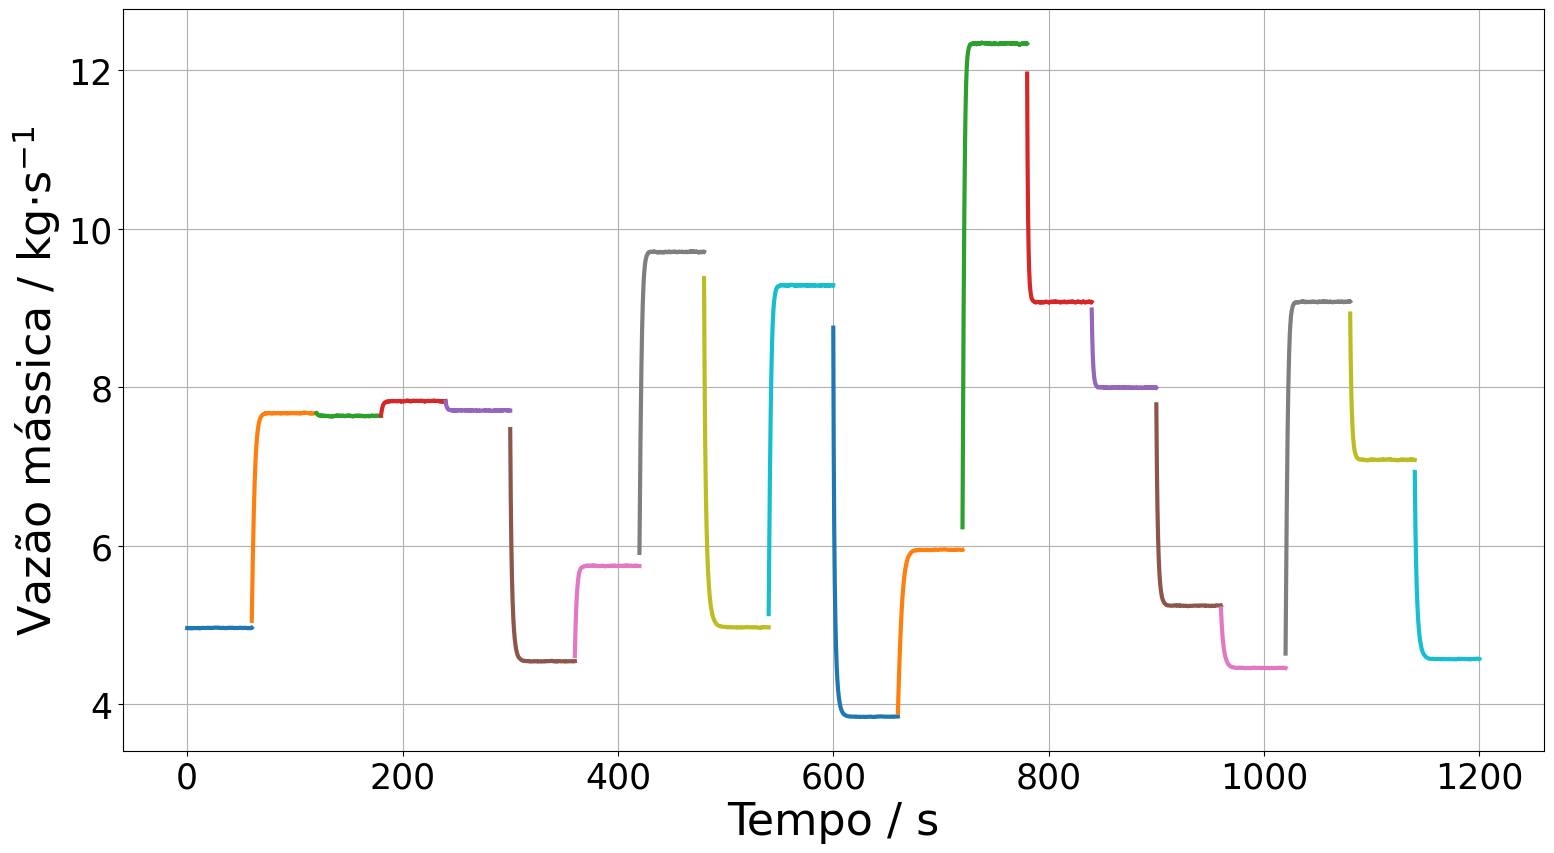

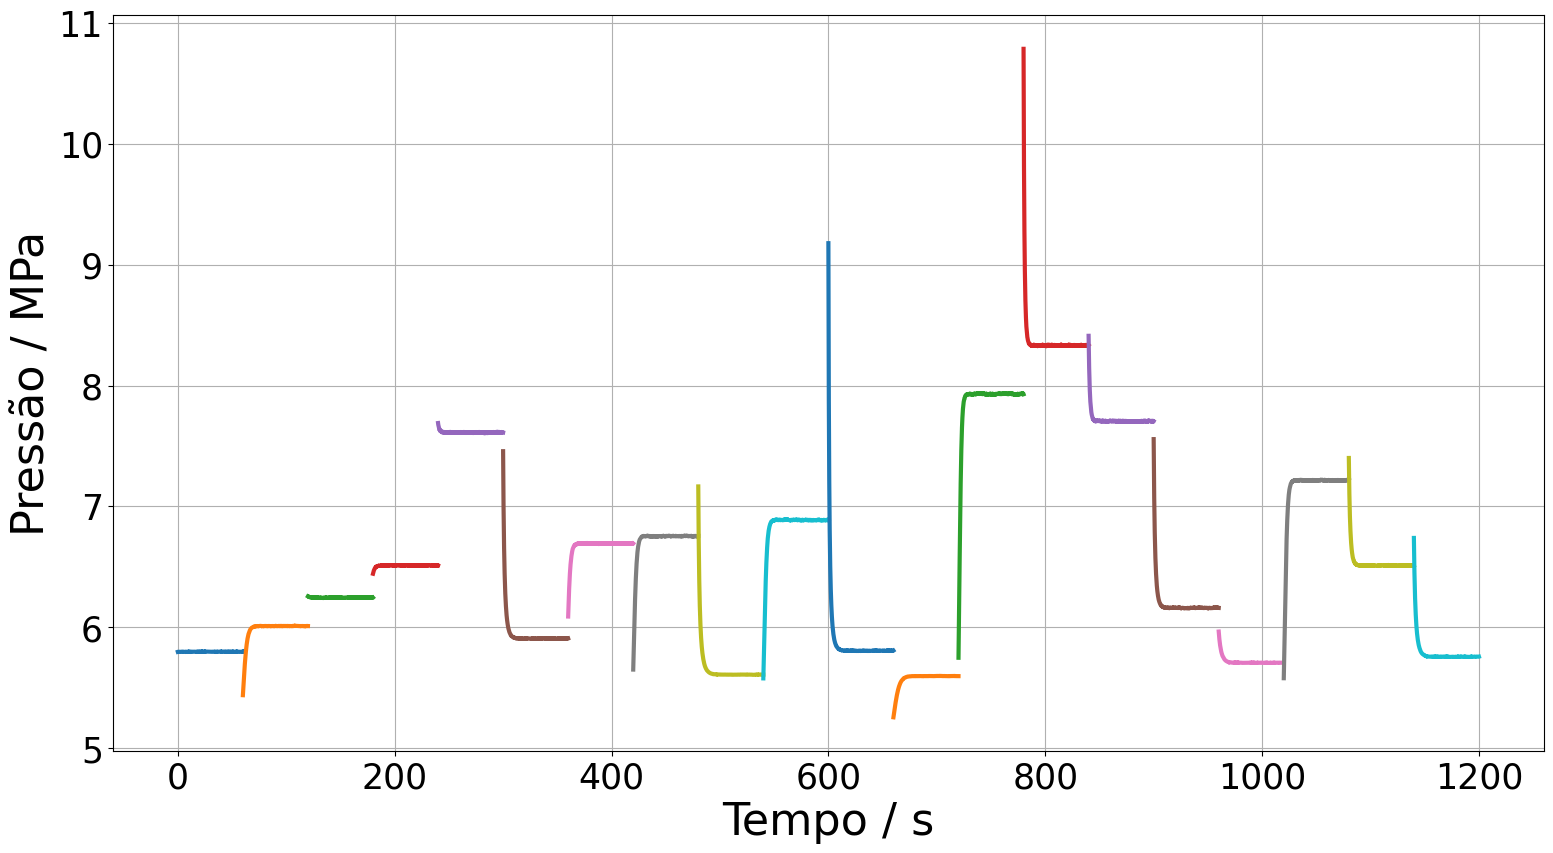

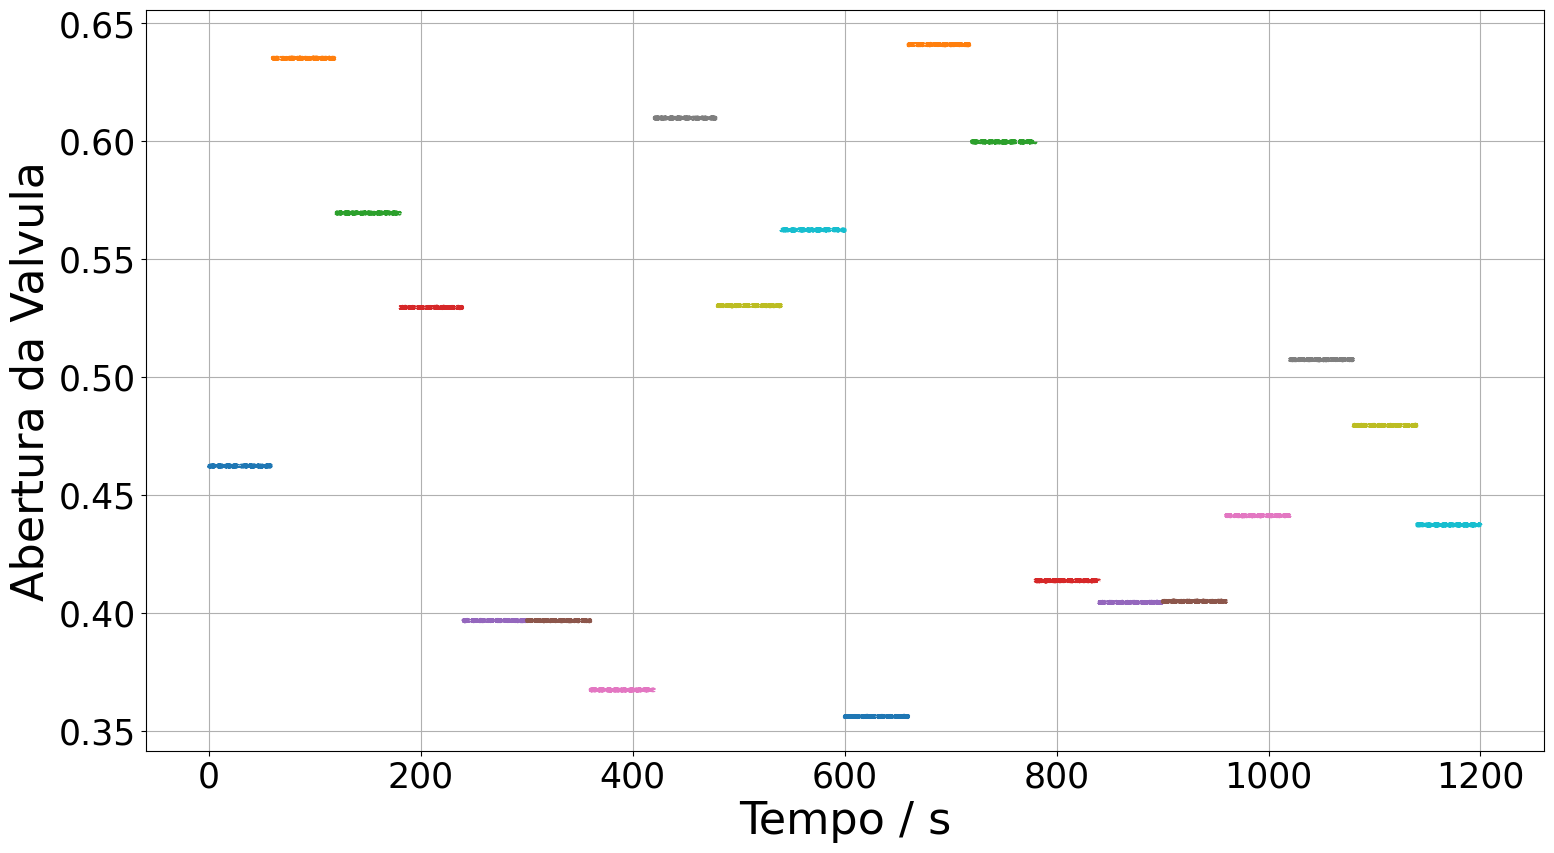

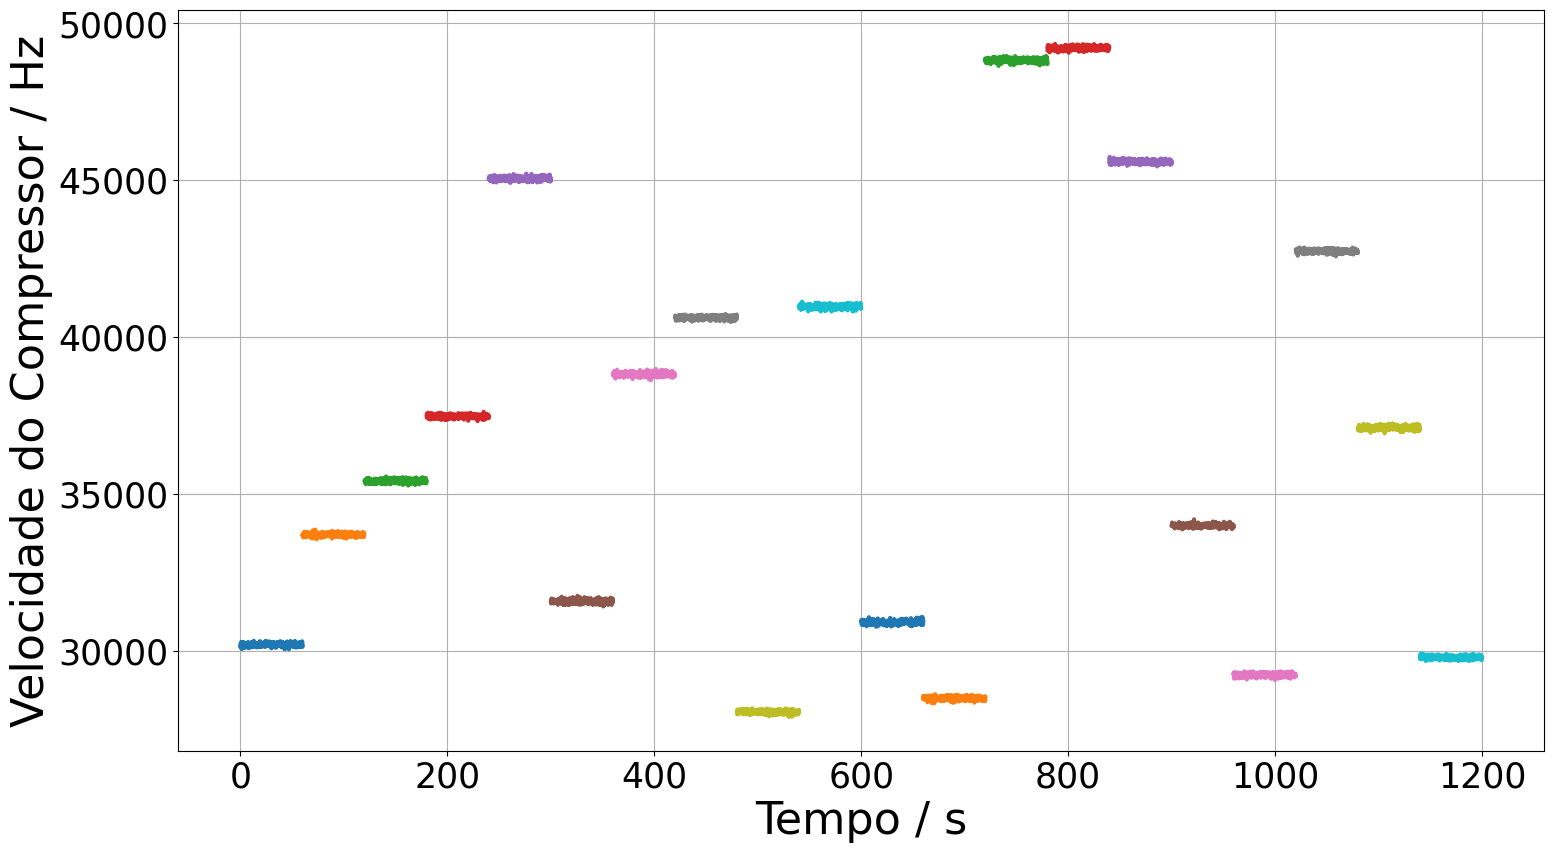

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Atualizar parâmetros de fonte
plt.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 24,
    'axes.labelsize': 32,
    'xtick.labelsize': 25,
    'ytick.labelsize': 25,
})

# Gráfico 1: Vazão vs Tempo
plt.figure(figsize=(16, 9))
for i in range(nAlphas):
    plt.plot(interval[i], np.squeeze(massFlowrate[i]), linewidth=3)
plt.xlabel('Tempo / s')
plt.ylabel(r'Vazão mássica / kg$\cdot$s$^{-1}$')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Pressão vs Tempo
plt.figure(figsize=(16, 9))
for i in range(nAlphas):
    plt.plot(interval[i], np.squeeze(PlenumPressure[i]), linewidth=3)
plt.xlabel('Tempo / s')
plt.ylabel(r'Pressão / MPa')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 3: Alpha vs Tempo
plt.figure(figsize=(16, 9))
for i in range(nAlphas):
    plt.plot(interval[i], np.squeeze(alpha_values[i]), linestyle='dashed', linewidth=3)
plt.xlabel('Tempo / s')
plt.ylabel(r'Abertura da Valvula')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 4: Phi vs Tempo
plt.figure(figsize=(16, 9))
for i in range(nAlphas):
    plt.plot(interval[i], np.squeeze(N_values[i]), linestyle='dashed', linewidth=3)
plt.xlabel('Tempo / s')
plt.ylabel(r'Velocidade do Compressor / Hz')
plt.grid(True)
plt.tight_layout()
plt.show()


### Rede Neural

In [11]:
# import optuna
# from torch.utils.data import DataLoader

# def objective(trial):
#     # Definir os hiperparâmetros a serem otimizados
#     units = trial.suggest_int("units", 10, 100, step=10)
#     batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
#     lr = 1e-5
    
#     # Criar o modelo com o número de neurônios sugerido
#     model = MyModel(units, A1, Lc, kv, P1, P_out, C, dt, x_min, x_max, interpolation)
    
#     # Configurar o DataLoader com o batch_size sugerido
#     train_dataset = TensorDataset(X_train, y_train)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
#     # Configurar o otimizador com a taxa de aprendizado sugerida
#     optimizer = optim.Adam(model.parameters(), lr=lr)
    
#     # Treinamento
#     model.train()
#     epochs = 100  # Escolha o número de épocas desejado para avaliação
#     for epoch in range(epochs):
#         total_loss = 0
#         for inputs, y_true in train_loader:
#             optimizer.zero_grad()
#             y_pred = model(inputs)
#             loss = model.loss_custom(y_true, y_pred, inputs)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
    
#     # Retornar o valor médio da perda como métrica de avaliação
#     return total_loss / len(train_loader)

# # Criar o estudo Optuna
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)

# # Resultados
# print("Best trial:")
# print(f"  Units: {study.best_params['units']}")
# print(f"  Batch size: {study.best_params['batch_size']}")

##### Treinamento

In [12]:
model = MyModel(128, A1, Lc, kv, P1, P_out, C, dt, x_min, x_max, interpolation)
train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= 64, shuffle=False)
Adam = optim.Adam
train_loss_values, val_loss_values, phys_loss_values, data_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=1e-5,
    epochs=200,
    optimizers=torch.optim.Adam,
    patience=100,
    factor=0.5
)

/home/matheus/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


tensor([[45.8373, 39.9077, 41.3490, 22.3321, 44.2007, 28.4028, 49.4545, 31.5864,
         40.9183, 45.8394, 44.1911, 45.8246, 45.8733, 22.3778, 35.0923, 13.4386,
          9.6689, 48.1245, 45.8655, 41.3444, 47.8087, 51.2318, 45.8601, 45.2706,
         31.7169, 35.1315, 51.5085, 13.3616, 22.3626, 29.3618, 35.1474, 48.5457,
         28.3418, 24.6465, 15.1045, 35.0799, 47.8163, 51.4946, 15.1366, 13.4451,
         22.3851, 45.8700, -4.3300, 13.3817, 44.1726, 13.4196,  9.6128, 35.0968,
         47.8368, 31.6762, 31.6277, 48.6105, 44.1709, 31.6591, 35.0934,  9.6541,
         31.6470, 32.2083, 31.6711, 51.4891, 30.8331, 15.0788, 15.0267, 47.8231]],
       grad_fn=<DivBackward0>)
tensor([[30.8222, 51.5049, 47.6790, 13.4422, 35.0981, 22.4135, 31.6495, 39.9426,
         39.9326,  1.8584, 28.3687, 50.9879, 49.4567, 31.6785, 41.3422, 35.1166,
         22.3865, 47.6399, 35.0806, 28.4092, 47.8678,  2.0293, 49.4478, 15.0529,
         22.3493, 41.7975, 49.4473, 15.0495, 51.4967, 51.5012, 13.3687,  2.0

KeyboardInterrupt: 

##### Dados de teste

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_values) + 1)


plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_values, label='Training Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')  # Aumenta o tamanho do texto do xlabel
plt.ylabel('Loss')    # Aumenta o tamanho do texto do ylabel
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, data_loss_values, label='Data Loss', color='red')
plt.plot(epochs, phys_loss_values, label='Phys Loss', color='blue')
plt.plot(epochs, train_loss_values, label='Total Loss', color='black')
plt.xlabel('Epochs', fontsize=14)  # Aumenta o tamanho do texto do xlabel
plt.ylabel('Loss', fontsize=14)    # Aumenta o tamanho do texto do ylabel
plt.yscale('log')

# Define a escala do eixo X de 100 em 100
plt.xticks(ticks=range(0, len(epochs) + 1, 300))

plt.legend()
plt.grid()
plt.show()

In [ ]:
massFlowrateTeste = []
PlenumPressureTeste = []
RNN_test = []
x_test = []
alpha_valuesTeste = []
aux1 = []
aux2 = []
alphasTeste = np.random.uniform(0.35,0.65, nAlphasTeste) # Abertura da válvula
N_RotSTeste = np.random.uniform(27e3, 5e4, nAlphasTeste+1)

sim = Simulation(A1, Lc, kv, P1, P_out, C, alphasTeste,N_RotSTeste, nAlphasTeste, nDataTeste, perturb, tempoTeste, dt, interpolation, timestep, 'idas')

sim.run()

massFlowrateTeste = sim.massFlowrate
PlenumPressureTeste = sim.PlenumPressure
alpha_valuesTeste = sim.alpha_values
x_test = sim.X_train
print(sim.time)


massFlowrateTeste = np.array(massFlowrateTeste)
PlenumPressureTeste = np.array(PlenumPressureTeste)
interval3 = np.linspace(0, tempoTeste*nAlphasTeste, len(x_test))

##### Gráfico Rede Neural

In [ ]:
massFlowrate100, PlenumPressure100,time2 = model.test_model(x_test, interval3, model)
print(time2)

In [ ]:
fig3 = make_subplots(rows=1, cols=2, subplot_titles=("Mass Flow Rate vs Time", "Plenum Pressure vs Time"))

fig3.add_trace(go.Scatter(x=interval3,y=np.squeeze(massFlowrate100),mode='lines',
                                line=dict(dash='solid')),row=1, col=1)
fig3.add_trace(go.Scatter(x=interval3,y=np.squeeze(PlenumPressure100),mode='lines',
                                line=dict(dash='solid')),row=1, col=2)

for i in range(nAlphasTeste):
    # Modelo
    fig3.add_trace(go.Scatter(x=np.squeeze(interval_test[i]), y=np.squeeze(massFlowrateTeste[i]), mode='lines',name='Model Mass Flow Rate', line=dict(dash='dash', color='red')),
                  row=1, col=1)
    fig3.add_trace(go.Scatter(x=np.squeeze(interval_test[i]), y=np.squeeze(PlenumPressureTeste[i]), mode='lines', name= 'Model Plenum Pressure', line=dict(dash='dash', color='red')),
                  row=1, col=2)

fig3.update_layout(
    title='Resultados Rede Neural',
    xaxis_title='Time',
    yaxis_title='Value',
    template='plotly',
    showlegend=False
)
fig3.show()

In [ ]:
torch.onnx.export(
    model,                           # Modelo treinado
    x_test,                     # Exemplo de entrada
    "modelo.onnxD",                   # Nome do arquivo de saída
    export_params=True,              # Exporta os parâmetros do modelo
    opset_version=11,                # Versão do conjunto de operadores ONNX
    input_names=['input'],           # Nome(s) das entradas
    output_names=['output'],         # Nome(s) das saídas
    dynamic_axes={                   # Configuração para entradas dinâmicas
        'input': {0: 'batch_size'},  # O eixo 0 da entrada é dinâmico (batch size)
        'output': {0: 'batch_size'}  # O eixo 0 da saída também é dinâmico
     }
 )

In [ ]:
import torch
import onnx
import numpy as np
import time
import onnxruntime as ort

# Carregar o modelo ONNX
onnx_model_path = "./modelo.onnxD"
onnx_session = ort.InferenceSession(onnx_model_path)

# Preparar os dados de entrada
# Assumindo que você tenha um tensor de teste `x_test` e o intervalo `interval`
input_tensor = torch.zeros((1, 3, 4), dtype=torch.float32)

# Exemplo de inicialização para massFlowrate e PlenumPressure
massFlowrate_pred = [x_test[0, 0, 0].item(), x_test[0, 1, 0].item(), x_test[0, 2, 0].item()]
PlenumPressure_pred = [x_test[0, 0, 1].item(), x_test[0, 1, 1].item(), x_test[0, 2, 1].item()]

# Teste de previsão com o modelo ONNX
tm1 = time.time()
for i in range(len(interval3)):
    # Atualizar os valores do tensor diretamente
    input_tensor[0, :, 0] = torch.tensor(massFlowrate_pred[-3:])
    input_tensor[0, :, 1] = torch.tensor(PlenumPressure_pred[-3:])
    input_tensor[0, :, 2] = x_test[i, :, 2]
    input_tensor[0, :, 3] = x_test[i, :, 3]

    # Previsão com desativação do gradiente
    onnx_inputs = {'input': input_tensor.numpy()}
    onnx_outputs = onnx_session.run(None, onnx_inputs)
    
    # Adicionar previsões diretamente
    massFlowrate_pred.append(onnx_outputs[0][0, 0, 0])
    PlenumPressure_pred.append(onnx_outputs[0][0, 0, 1])
tm2 = time.time()
timeteste = tm2 - tm1

# Exibir tempo de execução
print(f"Tempo de teste: {timeteste}s")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ajustar os tamanhos de x e y se necessário
interval3 = interval3[:min(len(interval3), len(massFlowrate_pred))]
massFlowrate_pred = massFlowrate_pred[:len(interval3)]

plt.rcParams.update({
    'font.size': 22,  # Aumenta o tamanho da fonte geral
    'axes.titlesize': 24,  # Tamanho do título dos eixos
    'axes.labelsize': 32,  # Tamanho dos rótulos dos eixos
    'xtick.labelsize': 25,  # Tamanho dos rótulos do eixo X
    'ytick.labelsize': 25,  # Tamanho dos rótulos do eixo Y
    'legend.fontsize': 25,  # Tamanho da fonte da legenda
})

# Gráfico 1: Vazão prevista pela RNA
plt.figure(figsize=(16, 9))
plt.plot(interval3, np.squeeze(massFlowrate_pred[:]), label='Vazão prevista pela PINN', linestyle='solid', linewidth = 3, color = 'black')
for i in range(nAlphasTeste):
    # Alinhar tamanhos nos dados de teste também
    interval_test[i] = interval_test[i][:min(len(interval_test[i]), len(massFlowrateTeste[i]))]
    massFlowrateTeste[i] = massFlowrateTeste[i][:len(interval_test[i])]
    
    showlegend_mass = i == 0  # Apenas a primeira iteração terá legenda visível
    plt.plot(
        np.squeeze(interval_test[i]),
        np.squeeze(massFlowrateTeste[i]),
        label='Previsão CasADi' if showlegend_mass else None,
        linestyle='--',
        color='red',
        linewidth=4
    )
plt.xlabel('Tempo / s')
plt.ylabel(r'Vazão mássica / kg$\cdot$s$^{-1}$')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# Gráfico 2: Pressão prevista pela RNA
interval3 = interval3[:min(len(interval3), len(PlenumPressure_pred))]
PlenumPressure_pred = PlenumPressure_pred[:len(interval3)]

plt.figure(figsize=(16, 9))
plt.plot(interval3, np.squeeze(PlenumPressure_pred[:]), label='Pressão prevista pela PINN', linestyle='solid', linewidth = 3, color = 'black')
for i in range(nAlphasTeste):
    # Alinhar tamanhos nos dados de teste também
    interval_test[i] = interval_test[i][:min(len(interval_test[i]), len(PlenumPressureTeste[i]))]
    PlenumPressureTeste[i] = PlenumPressureTeste[i][:len(interval_test[i])]
    
    showlegend_pressure = i == 0  # Apenas a primeira iteração terá legenda visível
    plt.plot(
        np.squeeze(interval_test[i]),
        np.squeeze(PlenumPressureTeste[i]),
        label='Previsão CasADi' if showlegend_pressure else None,
        linestyle='--',
        color='red',
        linewidth=4
    )
plt.xlabel('Tempo / s')
plt.ylabel('Pressão do Plenum / MPa')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=False)
plt.tight_layout()
plt.show()